Davide Cremonini 14412 - Davide Sbetti 14032

---

# Driving Drowsiness Detection - Model definition

This notebook represents the definition of the predictive model we would like to use to detect closing eyes in real time.

# Colab code

Since this notebook was run on Google Colab (with an activate GPU for performance reasons), we have some dedicated code that will check out the Github repository corresponding to this project, in order to obtain the necessary data. 

If we are not running the notebook on Colab, we set the path of the dataset to the local one. 

In [1]:
if 'google.colab' in str(get_ipython()):
  !apt install subversion
  !svn checkout https://github.com/sbettid/ATML_Project_202021
  # connect to the datasets
  closed_eyes_dataset_path = "/content/ATML_Project_202021/trunk/mrlEyes_2018_01"
else:
  closed_eyes_dataset_path = "mrlEyes_2018_01"

Output streaming troncato alle ultime 5000 righe.
A    ATML_Project_202021/trunk/mrlEyes_2018_01/val/1/s0031_01331_1_0_1_2_1_02.png
A    ATML_Project_202021/trunk/mrlEyes_2018_01/val/1/s0031_01333_1_0_1_2_1_02.png
A    ATML_Project_202021/trunk/mrlEyes_2018_01/val/1/s0031_01334_1_0_1_0_1_02.png
A    ATML_Project_202021/trunk/mrlEyes_2018_01/val/1/s0031_01335_1_0_1_2_1_02.png
A    ATML_Project_202021/trunk/mrlEyes_2018_01/val/1/s0031_01345_1_0_1_2_1_02.png
A    ATML_Project_202021/trunk/mrlEyes_2018_01/val/1/s0031_01351_1_0_1_2_1_02.png
A    ATML_Project_202021/trunk/mrlEyes_2018_01/val/1/s0031_01352_1_0_1_2_1_02.png
A    ATML_Project_202021/trunk/mrlEyes_2018_01/val/1/s0031_01354_1_0_1_2_1_02.png
A    ATML_Project_202021/trunk/mrlEyes_2018_01/val/1/s0031_01356_1_0_1_2_1_02.png
A    ATML_Project_202021/trunk/mrlEyes_2018_01/val/1/s0031_01358_1_0_1_0_1_02.png
A    ATML_Project_202021/trunk/mrlEyes_2018_01/val/1/s0031_01363_1_0_1_0_1_02.png
A    ATML_Project_202021/trunk/mrlEyes_2018_01/v

# Import required libraries

We import then the required libraries

In [2]:
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Data Exploration

We start by analysing the images we have in our dataset and, in particular, the distribution between the different classes, in order to check if the dataset is balanced.

In [3]:
train_close = len(os.listdir('/content/ATML_Project_202021/trunk/mrlEyes_2018_01/train/0/'))
train_open = len(os.listdir('/content/ATML_Project_202021/trunk/mrlEyes_2018_01/train/1/'))

val_close = len(os.listdir('/content/ATML_Project_202021/trunk/mrlEyes_2018_01/val/0/'))
val_open = len(os.listdir('/content/ATML_Project_202021/trunk/mrlEyes_2018_01/val/1/'))

total_close = train_close + val_close
total_open = train_open + val_open

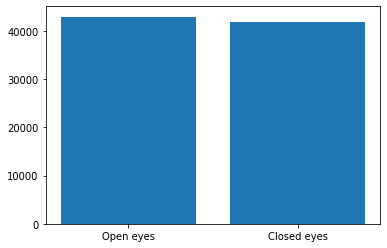

In [4]:
plt.bar(["Open eyes", "Closed eyes"],[total_open, total_close])
plt.show()

We can see from the previous plot that we are dealing with a really balanced dataset. 

Following, we present some example pictures of both classes:

In [18]:
train_ex_img_closed = os.listdir('/content/ATML_Project_202021/trunk/mrlEyes_2018_01/train/0/')[:9]
train_ex_img_open = os.listdir('/content/ATML_Project_202021/trunk/mrlEyes_2018_01/train/1/')[:9]

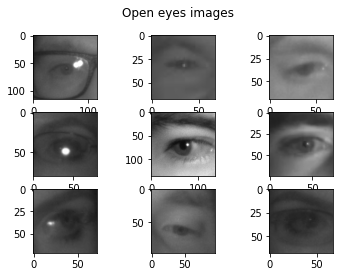

In [21]:
i = 1
path = '/content/ATML_Project_202021/trunk/mrlEyes_2018_01/train/1/'
for img in train_ex_img_open:
  #reading the image
  image = cv2.imread(path + img)
  plt.subplot(3,3,i)
  plt.imshow(image)

  i = i + 1

fig = plt.gcf()
fig.suptitle("Open eyes images")
plt.show()

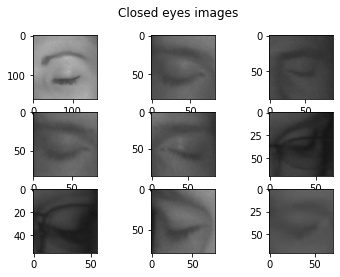

In [22]:
i = 1
path = '/content/ATML_Project_202021/trunk/mrlEyes_2018_01/train/0/'
for img in train_ex_img_closed:
  #reading the image
  image = cv2.imread(path + img)
  plt.subplot(3,3,i)
  plt.imshow(image)

  i = i + 1

fig = plt.gcf()
fig.suptitle("Closed eyes images")
plt.show()

## Reading the dataset and splitting

We prepare then a pre-processing function that we apply to each image, in order to convert it to a gray scale and to obtain still a three level image. 
This is necessary since the pre-trained network we would like to use expects an image with three channels. 

This transformation was necessary, not for training reasons, since the images are already in a gray scale (with 3 channels), but to unify and apply the same pre-processing technique to the frames captured in real time by a camera, which are colored images with 3 channels. 

In [ ]:
def color_to_3gray(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img2 = np.zeros_like(img)
  img2[:,:,0] = gray
  img2[:,:,1] = gray
  img2[:,:,2] = gray

  return img2

We then read the images using the Image Generator class, splitting the validation set in two equally sized datasets (validation and test sets). 

Moreover, we apply some data augmentation techniques (flips, different brightness and zoom ranges and a random rotation) to obtain a more diverse dataset.

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=color_to_3gray, horizontal_flip=True, brightness_range=(0.2,0.8), zoom_range=(0.3,0.7), rotation_range=20)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5, preprocessing_function=color_to_3gray, horizontal_flip=True, brightness_range=(0.2,0.8), zoom_range=(0.3,0.7), rotation_range=20)

In [ ]:
train_generator = train_datagen.flow_from_directory(closed_eyes_dataset_path + "/train/",target_size=(80,80), class_mode="binary")

Found 59428 images belonging to 2 classes.


In [ ]:
val_generator = val_datagen.flow_from_directory(closed_eyes_dataset_path + "/val/",target_size=(80,80), subset="training", class_mode="binary")
test_generator = val_datagen.flow_from_directory(closed_eyes_dataset_path + "/val/",target_size=(80,80), subset="validation", class_mode="binary")

Found 12735 images belonging to 2 classes.
Found 12735 images belonging to 2 classes.


## Importing pre-trained model

For our classification task, we decided to use a pre-trained model, namely the Xception one (https://keras.io/api/applications/xception/). We import it using the pre-trained Imagenet weights and max pooling. 

In [ ]:
from tensorflow.keras.applications.xception import Xception

In [ ]:
xmodel = Xception(input_shape = (80,80,3), include_top = False, weights = "imagenet", pooling="max")

83689472/83683744 [==============================] - 1s 0us/step


We then set all layers to be untrainable, except the last 5 (to increase the model accuracy).

In [ ]:
layers_num = len(xmodel.layers)

In [ ]:
i = 1

for layer in xmodel.layers:
    if layers_num - i <= 5:
        layer.trainable = True
    else:
        layer.trainable = False
    i += 1

In [ ]:
xmodel.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 39, 39, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 39, 39, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 39, 39, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

Now, we can define our own model that starts from the last layer of the pre-trained one 

**NOTE**: the name of the last layer sometimes changes. 

![Harry Potter changing stairs meme](https://github.com/sbettid/ATML_Project_202021/blob/main/staircase_meme.jpg?raw=1)


We flatten the output of the convolutional part of the network and we apply a dense layer of 512 units, followed by another layer with 256 units, applying also a dropout of 0.5 and 0.3 respectively and relu as the activation function.

Our last layer is composed by a single unit with the sigmoid function as activation. 

In [ ]:
last_layer = xmodel.get_layer('global_max_pooling2d')
last_output = last_layer.output

our_layer = keras.layers.Flatten()(last_output)
our_layer = keras.layers.Dense(512, activation='relu')(our_layer)
our_layer = keras.layers.Dropout(0.5)(our_layer)
our_layer = keras.layers.Dense(256, activation='relu')(our_layer)
our_layer = keras.layers.Dropout(0.3)(our_layer)
our_layer = keras.layers.Dense(1, activation='sigmoid')(our_layer)

We can so combine the two models. 

In [ ]:
model = keras.Model(xmodel.input,our_layer)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 39, 39, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 39, 39, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 39, 39, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

We can then compile the model using nadam as optimiser, the accuracy as metrics and the binary crossentropy as the loss function.

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])

After compiling the model, we can feed it with our training data, evaluating each epoch on the validation dataset. We train our network for 5 epochs. 

In [ ]:
history = model.fit(train_generator, validation_data=val_generator, epochs = 5)

Epoch 1/5
1858/1858 [==============================] - 174s 94ms/step - loss: 0.0945 - accuracy: 0.9666 - val_loss: 0.0940 - val_accuracy: 0.9641
Epoch 2/5
1858/1858 [==============================] - 174s 94ms/step - loss: 0.0916 - accuracy: 0.9680 - val_loss: 0.0911 - val_accuracy: 0.9644
Epoch 3/5
1858/1858 [==============================] - 174s 93ms/step - loss: 0.0862 - accuracy: 0.9700 - val_loss: 0.0956 - val_accuracy: 0.9650
Epoch 4/5
1858/1858 [==============================] - 174s 94ms/step - loss: 0.0857 - accuracy: 0.9700 - val_loss: 0.1321 - val_accuracy: 0.9531
Epoch 5/5
1858/1858 [==============================] - 173s 93ms/step - loss: 0.0832 - accuracy: 0.9702 - val_loss: 0.0827 - val_accuracy: 0.9710


We can observe how the accuracy on the validation set remains quite large, reaching a final accuracy of about 97%.

## Checking results on the test set

After having observed the good result on both the training set and the validation one, we evaluate the model on our test set. 

In [ ]:
model.evaluate(test_generator)

398/398 [==============================] - 31s 77ms/step - loss: 0.0682 - accuracy: 0.9747


[0.06821262091398239, 0.9747153520584106]

## Saving the model

Havin reached good performances, we save the model in order to apply it later in real time. 

In [ ]:
model.save("model.h5")